In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

# Parameters

In [2]:
iteration =2
PhenoGraph_k =  100
node_label = 'CellType'
size_smallest_cluster  = 20
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 95,
    'knn_k': 30
}
patient_filtering_dict = {
    # 'Clinical Subtype': 'HR+/HER2-',
}


# Subset 1

In [3]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

379 patients are included


In [4]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

379 patients are included
S1 (N = 26):
Survival: hr = 2.428013562030345, p = 0.0009529780614233097
	Significant
S2 (N = 48):
Survival: hr = 1.6715184635587368, p = 0.02843447397812587
S3 (N = 23):
Survival: hr = 1.1993259620126575, p = 0.6188721644067485
S4 (N = 73):
Survival: hr = 1.1496241238841327, p = 0.5148989278165488
S5 (N = 61):
Survival: hr = 0.9672335783354061, p = 0.8872245985054152
S6 (N = 51):
Survival: hr = 0.6150989479810047, p = 0.12382629829932304
S7 (N = 97):
Survival: hr = 0.514502885809581, p = 0.005382388188832714
	Significant


/tmp/ipykernel_255393/1459144472.py:9: RuntimeWarning: invalid value encountered in cast
  Grades_ = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Grade'].values[0] for patient_id in Patient_IDs]).astype(int)


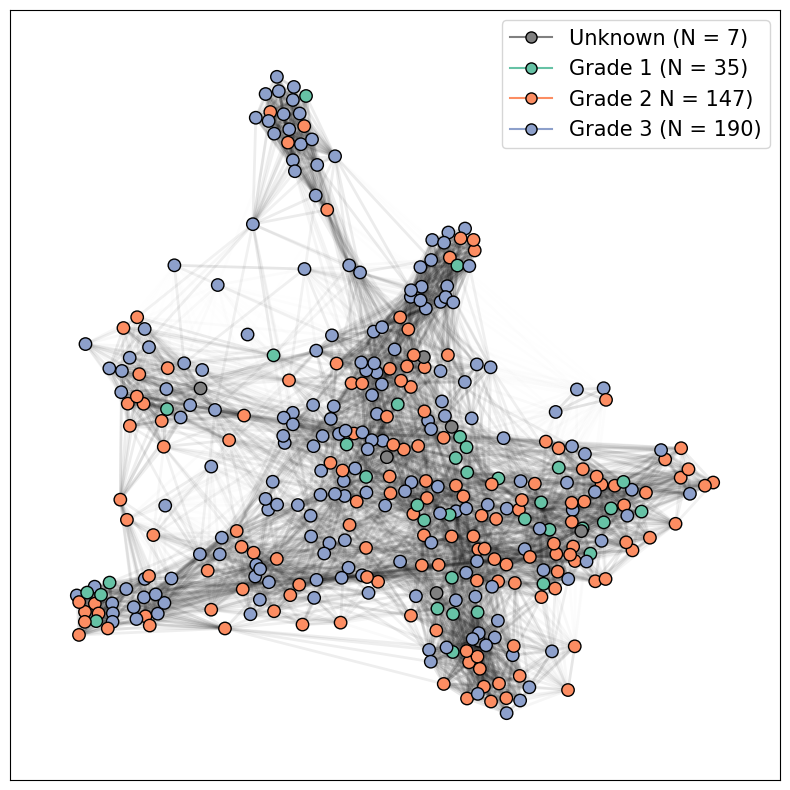

In [9]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    'knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
Grades_ = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Grade'].values[0] for patient_id in Patient_IDs]).astype(int)
Grades_[(Grades_ != 1) * (Grades_ != 2) * (Grades_!=3) ] = 0
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
    0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0
    for u, v in edge_list
]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
color_palette = ['grey'] + sns.color_palette("Set2")
nx.draw_networkx_nodes(
    G_population, pos, node_size=80, node_color=[color_palette[i] for i in Grades_], edgecolors="black"
)
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="grey",
        label="Unknown (N = {})".format(np.sum(Grades_ == 0)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[1],
        label="Grade 1 (N = {})".format(np.sum(Grades_ == 1)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[2],
        label="Grade 2 N = {})".format(np.sum(Grades_ == 2)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[3],
        label="Grade 3 (N = {})".format(np.sum(Grades_ == 3)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),




]
ax.legend(handles=handles, fontsize = 15)
plt.show()

In [10]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
Gram_matrix_ = Gram_matrix[np.array(np.where(Grades_ == 1)[0].tolist()), :][:, np.array(np.where(Grades_ == 1)[0].tolist())]
print("{} Grade 1 patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix[np.array(np.where(Grades_ == 2)[0].tolist()), :][:, np.array(np.where(Grades_ == 2)[0].tolist())]
print("{} Grade 2 patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix[np.array(np.where(Grades_ == 3)[0].tolist()), :][:, np.array(np.where(Grades_ == 3)[0].tolist())]
print("{} Grade 3 patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
print("{} Overall patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

35 Grade 1 patients, averaged Intra-group similarity is 0.25 
147 Grade 2 patients, averaged Intra-group similarity is 0.20 
190 Grade 3 patients, averaged Intra-group similarity is 0.17 
379 Overall patients, averaged Intra-group similarity is 0.18 


In [30]:
from scipy import stats
Overpresented_patterns = {}
for grade in [1,2,3]:
    Histogram_intra_group = Histograms_[Grades_ == grade]
    Overpresented_patterns[grade] = []
    Histogram_other_group = Histograms_[Grades_ != grade]
    candidates = []
    for other_subgroup_id in [
                i for i in [1,2,3] if i != subgroup_id
            ]:
        Histogram_other_group = Histograms_[Grades_ == other_subgroup_id]
        candidates = []
        for i in range(Histograms_.shape[1]):
            rvsi = Histogram_intra_group[:, i]
            rvso = Histogram_other_group[:, i]
            test_result = stats.mannwhitneyu(rvsi, rvso, alternative="greater")
            if (test_result.pvalue < 0.05/Histograms_.shape[1]):
                candidates.append(i)
                        # print(
                        #     "Pattern {} overpresented in S{} by {:.3f} times (p={:.5f})".format(
                        #         i,
                        #         subgroup_id,
                        #         np.mean(rvsi) / np.mean(rvso),
                        #         test_result.pvalue,
                        #         # existence_intra_group * 100,
                        #         # existence_out_group * 100,
                        #     )
                        # )
        Overpresented_patterns[grade].append(set(candidates))
    Overpresented_patterns[grade] = list(
                set.intersection(*Overpresented_patterns[grade])
            )
print(Overpresented_patterns)

{1: [], 2: [], 3: [18, 20, 45]}


grade 1
grade 2
grade 3
3
3
3


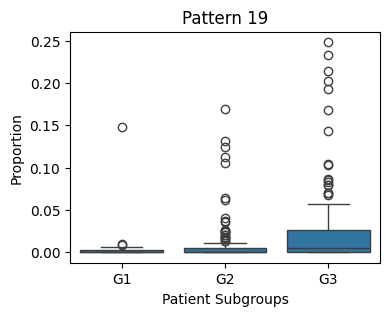

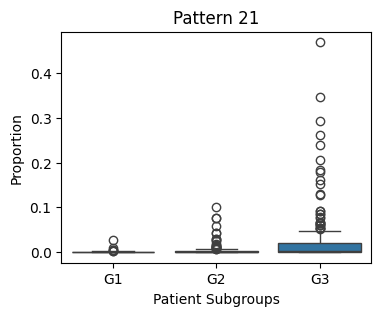

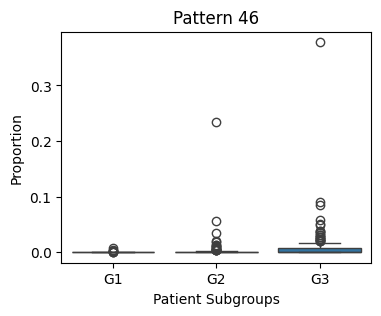

In [50]:
for grade, Candidates in Overpresented_patterns.items():
    print("grade {}".format(grade))
    for pattern_id in Candidates:
        histogram = Histograms_[:, pattern_id] 
        DF_presentation = pd.DataFrame(
                {
                    "Proportion": histogram,
                    "Grade": ['G'+str(int(i)) for i in Grades_],
                }
            )
        DF_presentation = DF_presentation.loc[DF_presentation["Grade"] != 0]
        f, ax = plt.subplots(figsize=(4, 3))
        sns.boxplot(
            x="Grade",
            y="Proportion",
            data=DF_presentation,
            showfliers=True,
            order=['G'+str(i) for i in range(1, 4)],
        )
        print(grade)
        # from statannotations.Annotator import Annotator
        # annot = Annotator(
        #     ax,
        #     [('G'+str(int(grade)), 'G'+str(i)) for i in [1,2,3] if i != grade],
        #     data=DF_presentation,
        #     x="Grade",
        #     y="Proportion",
        #     order=['G'+str(i) for i in range(1, 4)],
        # )
        # annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
        # annot.apply_test()
        # ax, test_results = annot.annotate()
        ax.set_title("Pattern {}".format(pattern_id+1))
        ax.set(ylabel = 'Proportion', xlabel = 'Patient Subgroups')


In [48]:
[('G'+str(int(grade)), 'G'+str(i)) for i in [1,2,3] if i != grade]

[('G3', 'G1'), ('G3', 'G2')]

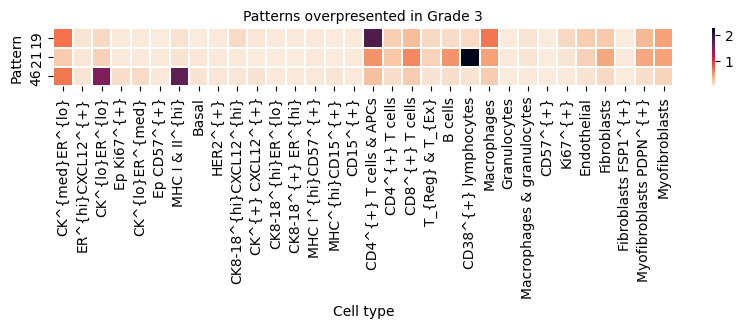

In [43]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
from definitions import get_node_id
from utils import reverse_dict

# Retrive cluster data
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel_random_split", "Danenberg", "Subset_1", 'Subtrees')
)
X = []
Cluster_identities = []
Indices = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    x = np.load(

        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            node_label,
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            node_label,
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".npy",
        )
    )
    indices = np.zeros(x.shape[0], dtype=int)
    indices[:] = i
    Indices.append(indices)
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)
Indices = np.concatenate(Indices, axis=0)
Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T
Cell_type_name_list = [reverse_dict(get_node_id("Danenberg", node_label))[i] for i in range(Centroids.shape[1])]

for subgroup_id, Candidates in Overpresented_patterns.items():
    # if len(Candidates) <=5:
    #     continue
    if len(Candidates) == 0:
        continue
    f, ax= plt.subplots(1,1,figsize=(10,0.25*len(Candidates)))
    sns.heatmap(
            Signature[:, np.array(Candidates)].T,
            ax=ax,
            cbar=True,
            cmap="rocket_r",
            linewidth=0.005,
            # edgecolor="black",
            # vmax=np.percentile(Signature, 99),
            # vmin=np.percentile(Signature, 1),
        )
    ax.set_xticklabels(Cell_type_name_list, rotation=90, fontsize=10)
    ax.set_yticklabels([i+1 for i in np.array(Candidates)], fontsize=10)
    # ax.set_ylabel("TME pattern index", fontsize=10)
    ax.set(xlabel = 'Cell type', ylabel = 'Pattern')
    ax.set_title(f"Patterns overpresented in Grade {subgroup_id}", fontsize=10)
    plt.show()



### Presentation of 4 clinical subtypes

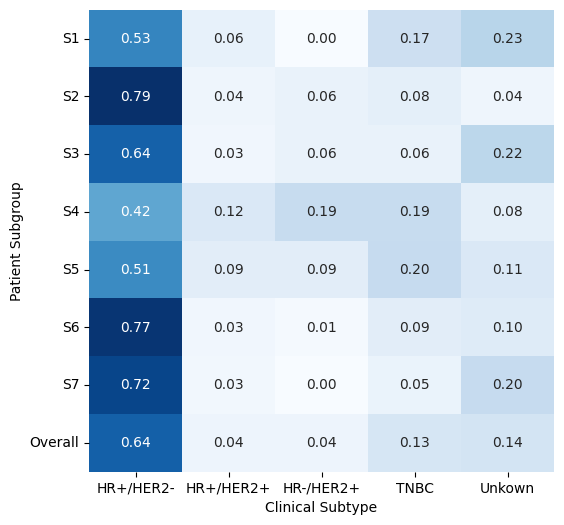

In [122]:
Clinical_subtypes_ = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_]
DF = pd.DataFrame({'subgroup_id' : ['S'+str(int(i)) for i in range(1, int(np.max(Subgroup_ids_))+1)] + ['Overall']})
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "nan"]:
        data = (np.array(Clinical_subtypes_) == clinical_subtype)*(np.array(Subgroup_ids_) == subgroup_id)
        exisitence_ratio = np.sum(data > 0) / np.sum((np.array(Subgroup_ids_) == subgroup_id))
        DF.loc[DF['subgroup_id'] == 'S'+str(int(subgroup_id)), clinical_subtype] = exisitence_ratio
        
for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan']:
    data = (np.array(Clinical_subtypes_) == clinical_subtype)
    exisitence_ratio = np.sum(data > 0) / len(data)
    DF.loc[DF['subgroup_id'] == 'Overall', clinical_subtype] = exisitence_ratio

f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(DF.values[:,1:].astype('float'), ax=ax, cmap="Blues", annot=True, fmt=".2f", cbar = False)
ax.set_xlabel("Clinical Subtype")
ax.set_ylabel("Patient Subgroup")
ax.set_xticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", "Unkown"], rotation=0)
ax.set_yticklabels(DF.values[:,0], rotation=0)
plt.show()


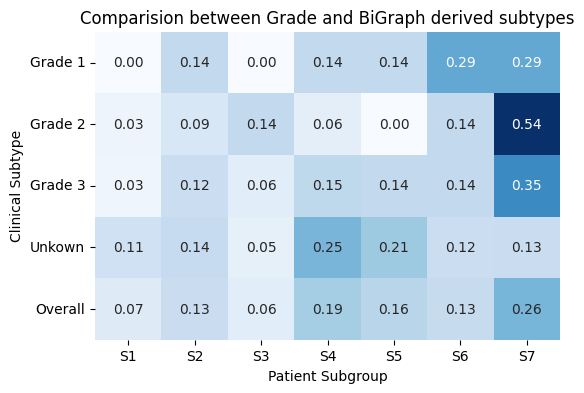

In [14]:

DF = pd.DataFrame({'Grade' : [0,1,2,3,'Overall']})
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    for grade in [0,1,2,3]:
        data = (np.array(Grades_) == grade)*(np.array(Subgroup_ids_) == subgroup_id)
        exisitence_ratio = np.sum(data > 0) / np.sum((np.array(Grades_) == grade))
        DF.loc[DF['Grade'] ==grade,  'S'+str(int(subgroup_id))] = exisitence_ratio
        
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    data = (np.array(Subgroup_ids_) == subgroup_id)
    exisitence_ratio = np.sum(data > 0) / len(data)
    DF.loc[DF['Grade'] == 'Overall', 'S'+str(int(subgroup_id))] = exisitence_ratio

# for grade in [0,1,2,3]:
#     data = np.array(Grades_) == grade
#     exisitence_ratio = np.sum(data > 0) / len(data)
#     DF.loc[DF['Grade'] == grade, 'Overall'] = exisitence_ratio
# DF.loc[DF['Grade'] == 'Overall', 'Overall'] = len(Grades_)/len(Grades_)
# print(DF.values)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(DF.values[:,1:].astype('float'), ax=ax, cmap="Blues", annot=True, fmt=".2f", cbar = False)
ax.set_ylabel("Clinical Subtype")
ax.set_xlabel("Patient Subgroup")
ax.set_yticklabels(["Grade 1", "Grade 2", "Grade 3", "Unkown",   'Overall'], rotation=0)
ax.set_xticklabels(['S'+str(i) for i in range(1, int(np.max(Subgroup_ids_)+1))],rotation=0)
ax.set(title = "Comparision between Grade and BiGraph derived subtypes")
plt.show()


In [28]:
data = (np.array(Clinical_subtypes_) == 'TNBC')*(np.array(Subgroup_ids_) == 2)
print(Patient_IDs_[data])

[ 869  350  292  191  188  401  660  659  174  340 2771 2849 3567 3453
  464 2993]


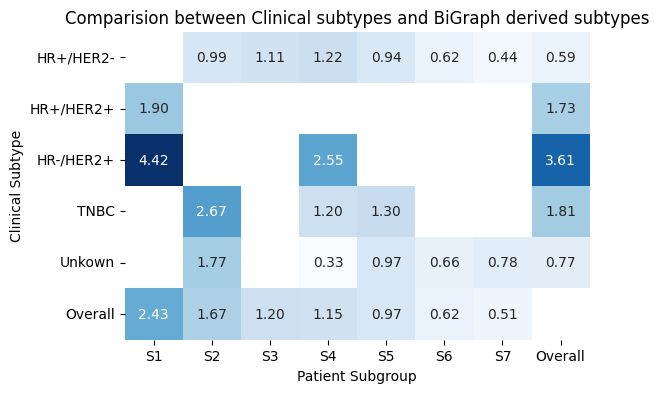

In [25]:
cph = CoxPHFitter()
Clinical_subtypes_ = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_]
DF = pd.DataFrame({'clinical_subtype' : ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan', 'Overall']})
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan']:
        data = (np.array(Clinical_subtypes_) == clinical_subtype)*(np.array(Subgroup_ids_) == subgroup_id)
        if data.sum()>=5:
            cph.fit(pd.DataFrame({'Length': Length, 'Status': Status, 'flag': data}), 'Length', event_col='Status')
            DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'S'+str(int(subgroup_id))] = cph.hazard_ratios_[0]
        else:
            DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'S'+str(int(subgroup_id))] = np.nan

        
for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
    data = (np.array(Subgroup_ids_) == subgroup_id)
    if data.sum()>=5:
        length, status = Length_[data], Status_[data]
        cph.fit(pd.DataFrame({'Length': Length, 'Status': Status, 'flag': data}), 'Length', event_col='Status')
        DF.loc[DF['clinical_subtype'] =='Overall',  'S'+str(int(subgroup_id))] = cph.hazard_ratios_[0]
    else:
        DF.loc[DF['clinical_subtype'] =='Overall',  'S'+str(int(subgroup_id))] = np.nan

for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'nan']:
    data = (np.array(Clinical_subtypes_) == clinical_subtype)
    if data.sum()>=5:
        cph.fit(pd.DataFrame({'Length': Length, 'Status': Status,'flag': data}), 'Length', event_col='Status')
        DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'Overall'] = cph.hazard_ratios_[0]
    else:
         DF.loc[DF['clinical_subtype'] ==clinical_subtype,  'Overall'] = np.nan

# print(DF.values)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(DF.values[:,1:].astype('float'), ax=ax, cmap="Blues", annot=True, fmt=".2f", cbar = False)
ax.set_ylabel("Clinical Subtype")
ax.set_xlabel("Patient Subgroup")
ax.set_yticklabels(["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC", 'Unkown',  'Overall'], rotation=0)
ax.set_xticklabels(['S'+str(i) for i in range(1, int(np.max(Subgroup_ids_)+1))] + ['Overall'] ,rotation=0)
ax.set(title = "Comparision between Clinical subtypes and BiGraph derived subtypes")
plt.show()


In [22]:
cph.hazard_ratios_

AttributeError: Must call `fit` first.

#### Fig. Comparision between Clinical subtypes and BiGraph derived subtypes
* The figure illustrates the proportion of seven subgroups within each individual clinical subtype. S1 is generally rare in the entire discovery cohort (7%). However, it becomes the majority subtype in HR+/HER2+ patients (69%) and HR-/HER2+ patients (50%). TNBC patients contains a larger proportion of S2 patients (32%) and S4 patients (40%) compared to the entire cohort (13% and 19%, respecitively). The proportion of S7 patients in HR+/HER2- (31%) is slightly higher than that in the entire cohort (26%). 

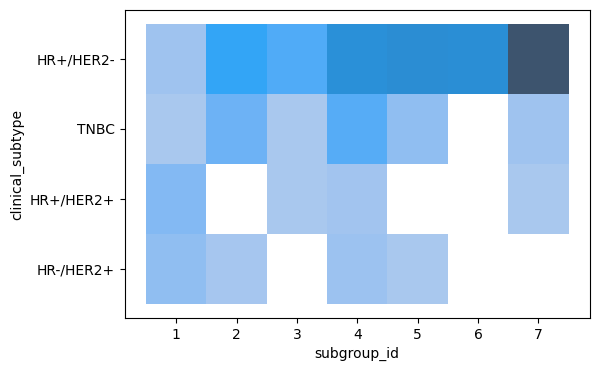

In [8]:
f, ax = plt.subplots(figsize=(6, 4))
Clinical_subtypes_ = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_]
DF = pd.DataFrame({'clinical_subtype' : Clinical_subtypes_, 'subgroup_id' : Subgroup_ids_})
sns.histplot(
    x="subgroup_id",
    y="clinical_subtype",
    # hue="clinical_subtype",
    data=DF,
    ax=ax,
    discrete=(True, True),
    shrink=0.8,
    legend=False,

#     hue_order=["S1", "S2", "S3", "S4", "S5", "S6", "S7"],
)
plt.show()

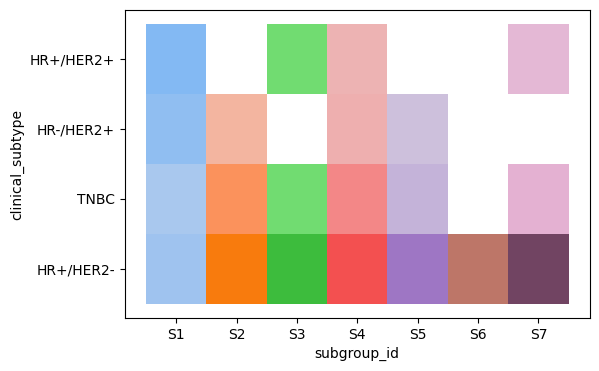

In [14]:
f, ax = plt.subplots(figsize=(6, 4))
sns.histplot(
    x="subgroup_id",
    y="clinical_subtype",
    hue="subgroup_id",
    data=DF,
    ax=ax,
    discrete=(True, True),
    shrink=0.8,
    legend=False,
#     hue_order=["S1", "S2", "S3", "S4", "S5", "S6", "S7"],
)
plt.show()

### K-M Plot

/tmp/ipykernel_255393/2503434450.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(figsize=(4, 4))


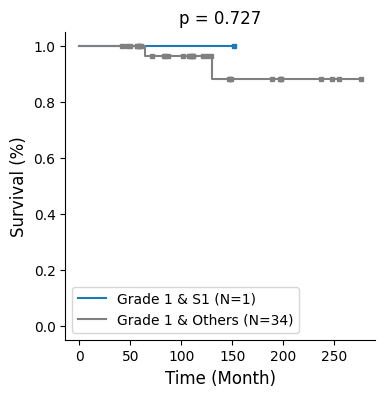

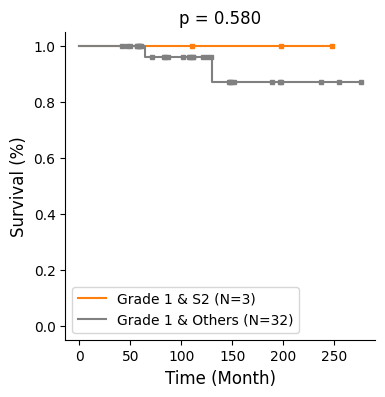

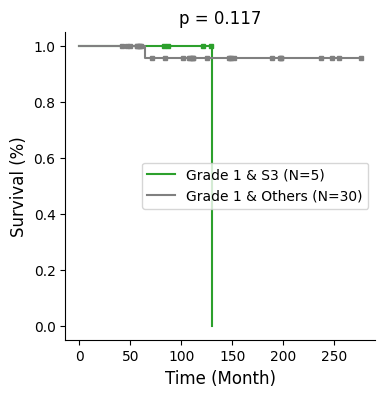

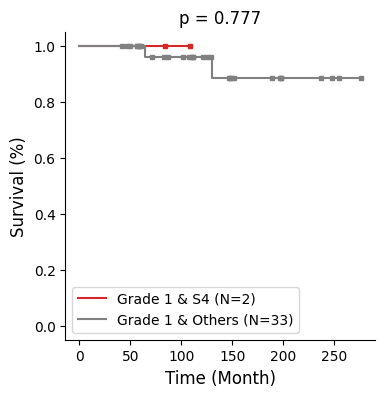

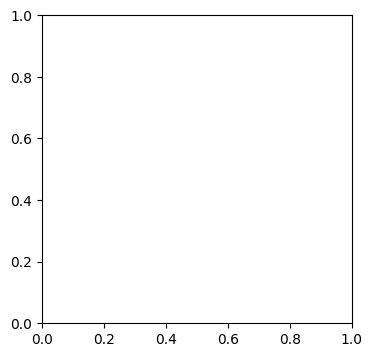

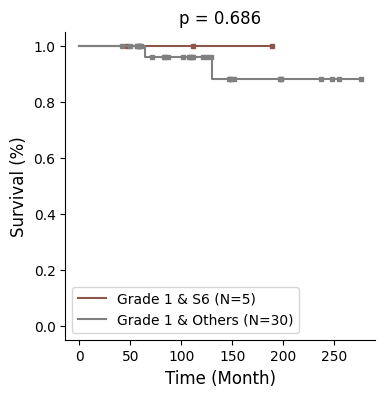

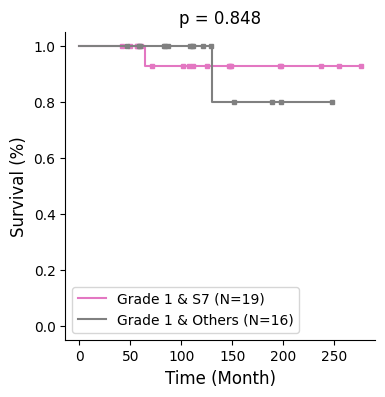

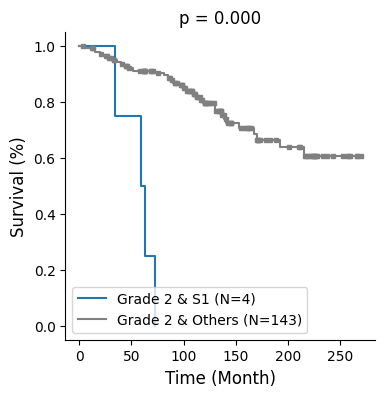

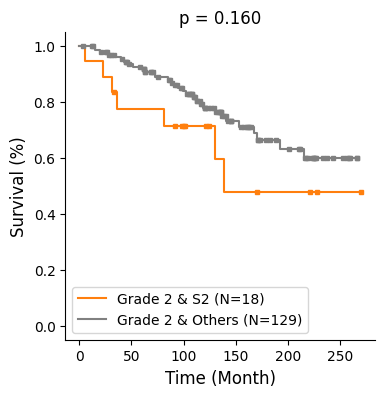

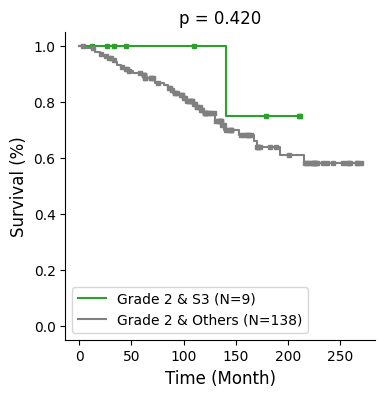

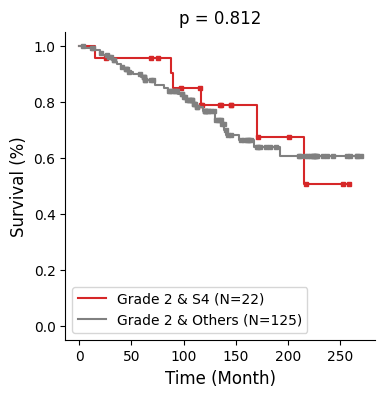

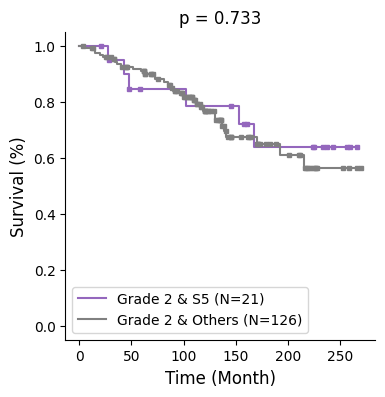

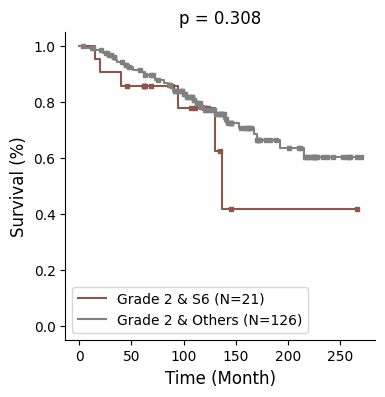

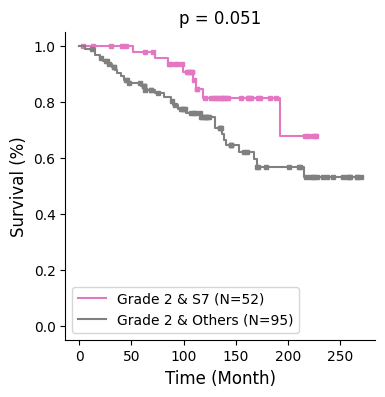

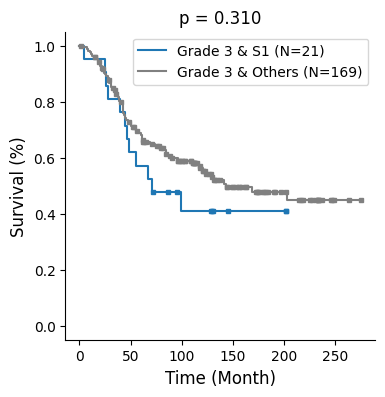

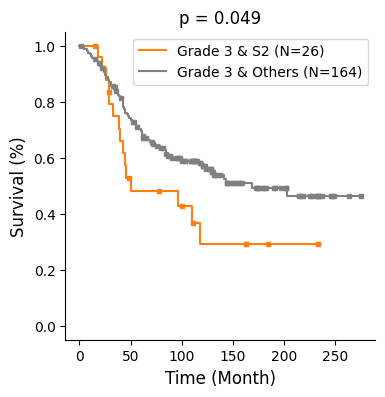

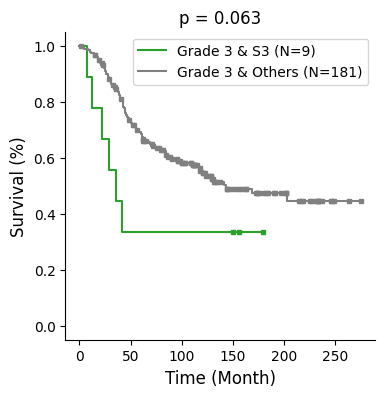

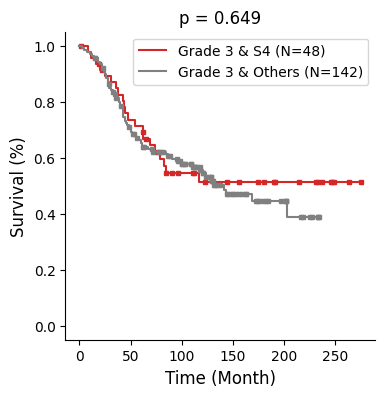

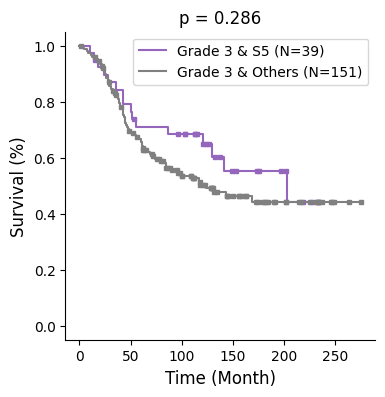

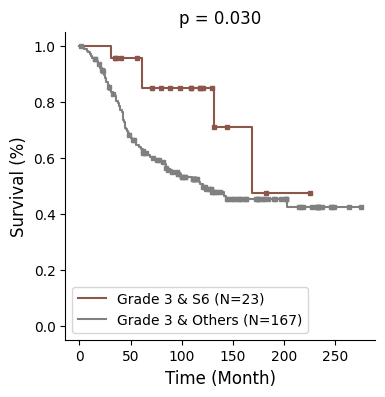

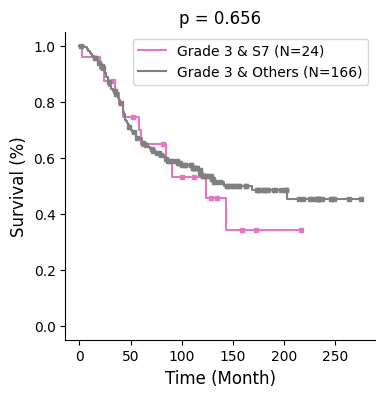

In [17]:
color_palette = sns.color_palette("tab10")
Length = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival (Months)"
        ].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
for grade in [1,2,3]:
    for subgroup_id in range(1, int(np.max(Subgroup_ids_)+1)):
        try:
            f, ax = plt.subplots(figsize=(4, 4))
            length_B, event_observed_B = (
                    Length[
                        (np.array(Grades_) == grade)  & (np.array(Subgroup_ids_) == subgroup_id) 
                    ],
                    Status[
                        (np.array(Grades_) == grade) & (np.array(Subgroup_ids_) == subgroup_id) 
                    ],
                )
            label = "Grade {} & S{} (N={})".format(grade, subgroup_id, len(length_B))
            kmf.fit(length_B, event_observed_B, label=label)
            kmf.plot_survival_function(
                    ax=ax,
                    ci_show=False,
                    color=color_palette[subgroup_id-1],
                    show_censors=True,
                    censor_styles={"ms": 3, "marker": "s"},
                )
            
            length_A, event_observed_A = (
                    Length[
                       (np.array(Grades_) == grade)   & (np.array(Subgroup_ids_) != subgroup_id) 
                    ],
                    Status[
                       (np.array(Grades_) == grade)  & (np.array(Subgroup_ids_) != subgroup_id) 
                    ],
                )
            label = "Grade {} & Others (N={})".format(grade, len(length_A))
            kmf.fit(length_A, event_observed_A, label=label)
            kmf.plot_survival_function(
                    ax=ax,
                    ci_show=False,
                    color='grey',
                    show_censors=True,
                    censor_styles={"ms": 3, "marker": "s"},
                )

            test = logrank_test(
                length_A,
                length_B,
                event_observed_A,
                event_observed_B,
                alpha=0.99,
                suppress_print=True,
            )
            p_value = test.p_value
            ax.set_title(
                "p = {:.3f}".format(p_value),
                fontsize=12,
            )
            
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
        except:
            pass

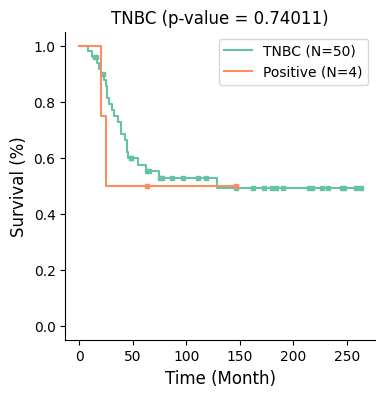

In [37]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="TNBC"
subgroup_id = 7
f, ax = plt.subplots(figsize=(4, 4))
# histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (np.array(Clinical_subtype) == clinical_subtype)
  
        ],
        Status[
            (np.array(Clinical_subtype) == clinical_subtype)

        ],
    )
label = "{} (N={})".format(clinical_subtype, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )


length_B, event_observed_B = (
        Length[
            (np.array(Clinical_subtype) == clinical_subtype)
            & (Subgroup_ids_ == subgroup_id)
   
        ],
        Status[
            (np.array(Clinical_subtype) == clinical_subtype)
             & (Subgroup_ids_ == subgroup_id)
        ],
    )
label = "Positive (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

log_rank_test = multivariate_logrank_test(
        np.concatenate([length_A, length_B]),
        [0] * len(length_A) + [1] * len(length_B),
        np.concatenate([event_observed_A, event_observed_B]),
    )
p_value = log_rank_test.p_value
ax.legend(fontsize=10)
ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# Subset 2

In [55]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
Histograms_cohort2 = Histograms_cohort2/np.sum(Histograms_cohort2, axis=1, keepdims=True)

Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival Status'].values[0] for i in Patient_IDs_cohort2]  
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

200 patients are included


In [56]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
from g_External_validation_random_split.Alignment import centroid_alignment_based_on_similarity
Gram_matrix_cohort2_ = get_Gram_matrix(Histograms_cohort2_)
Similarity_cohort2_discovery = get_Gram_matrix(np.concatenate([Histograms_cohort2_, Histograms_], axis=0))[:Histograms_cohort2_.shape[0], :][:, Histograms_cohort2_.shape[0]:]
assert Similarity_cohort2_discovery.shape[0] == Histograms_cohort2_.shape[0]
Subgroup_ids_cohort2_ = centroid_alignment_based_on_similarity(Similarity_cohort2_discovery, Subgroup_ids_)
print("{} patients are included".format(len(Patient_IDs_cohort2_)))

0.24216635256990027
200 patients are included


### Presentation in 4 clinical subtypes

3
8
11
1
36
0
0
5


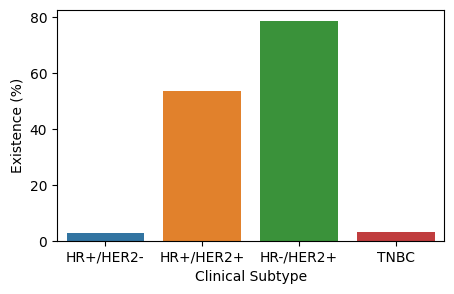

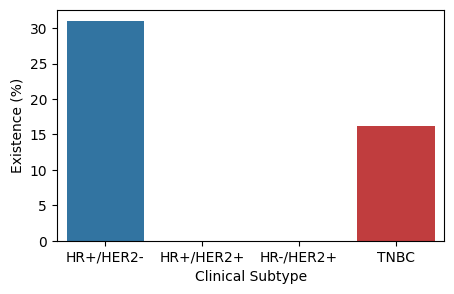

In [57]:

Clinical_subtype = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_cohort2_]

for subgroup_id in [1, 7]:
    DF_existence = pd.DataFrame({"Clinical Subtype": ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"]})
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"]:
        pattern_id = HR[subgroup_id-1]['community_id']
        data = (np.array(Clinical_subtype) == clinical_subtype)*(Subgroup_ids_cohort2_[:,subgroup_id-1] == 1)
        print(np.sum(data > 0))
        exisitence_ratio = np.sum(data > 0) / np.sum((np.array(Clinical_subtype) == clinical_subtype))
        DF_existence.loc[
            DF_existence["Clinical Subtype"] == clinical_subtype, "Existence (%)"
        ] = (exisitence_ratio * 100)
        # print(
        #     "Pattern {} in {} has {:.0f}% of patients".format(
        #         pattern_id, clinical_subtype, exisitence_ratio * 100
        #     )
        # )
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(
            x="Clinical Subtype",
            y="Existence (%)",
            data=DF_existence,
            order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
        )

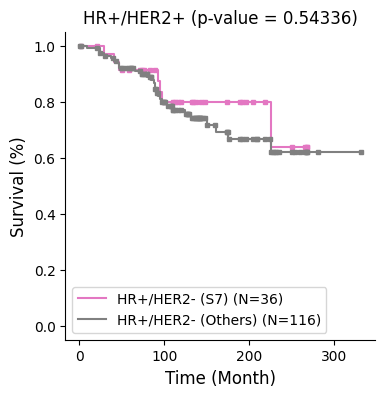

In [60]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival (Months)"
        ].values[0]
        for i in Patient_IDs_cohort2_
    ]
)
Status = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        for i in Patient_IDs_cohort2_
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype = "HR+/HER2+"
subgroup_id = 7
f, ax = plt.subplots(figsize=(4, 4))
length_B, event_observed_B = (
    Length[
        (np.array(Clinical_subtype) == "HR+/HER2-")* (Subgroup_ids_cohort2_[:,subgroup_id-1] == 1)
    ],
    Status[
        (np.array(Clinical_subtype) == "HR+/HER2-")* (Subgroup_ids_cohort2_[:,subgroup_id-1] == 1)
    ],
)
label = "HR+/HER2- (S7) (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=sns.color_palette("tab10")[6],
    show_censors=True,
    censor_styles={"ms": 3, "marker": "s"},
)

length_A, event_observed_A = (
    Length[
       (np.array(Clinical_subtype) == "HR+/HER2-")
        
    ],
    Status[
       (np.array(Clinical_subtype) == "HR+/HER2-")
   
    ],
)
label = "HR+/HER2- (Others) (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 3, "marker": "s"},
)


log_rank_test = multivariate_logrank_test(
    np.concatenate([length_A, length_B]),
    [0] * len(length_A) + [1] * len(length_B),
    np.concatenate([event_observed_A, event_observed_B]),
)
p_value = log_rank_test.p_value
ax.legend(fontsize=10)
ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
    ylim=(-0.05, 1.05),
)
sns.despine()

### K-M plot

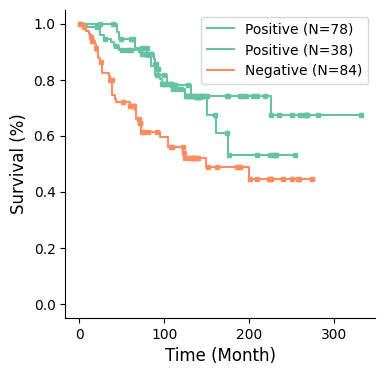

In [29]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival (Months)"
        ].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[
            clinical["patient_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype = "HR+/HER2+"
subgroup_id = 1
f, ax = plt.subplots(figsize=(4, 4))
length_B, event_observed_B = (
    Length[
        ((np.array(Clinical_subtype) == "HR+/HER2+")
        + (np.array(Clinical_subtype) == "HR-/HER2+")) * (Subgroup_ids_ == subgroup_id)
    ],
    Status[
        ((np.array(Clinical_subtype) == "HR+/HER2+")
        + (np.array(Clinical_subtype) == "HR-/HER2+"))* (Subgroup_ids_ == subgroup_id)
    ],
)
label = "HR+/HER2- (S7) (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=sns.color_palette("tab10")[6],
    show_censors=True,
    censor_styles={"ms": 3, "marker": "s"},
)

length_A, event_observed_A = (
    Length[
       ((np.array(Clinical_subtype) == "HR+/HER2+")
        + (np.array(Clinical_subtype) == "HR-/HER2+"))
    ],
    Status[
       ((np.array(Clinical_subtype) == "HR+/HER2+")
        + (np.array(Clinical_subtype) == "HR-/HER2+"))
    ],
)
label = "HR+/HER2- (Others) (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 3, "marker": "s"},
)


log_rank_test = multivariate_logrank_test(
    np.concatenate([length_A, length_B]),
    [0] * len(length_A) + [1] * len(length_B),
    np.concatenate([event_observed_A, event_observed_B]),
)
p_value = log_rank_test.p_value
ax.legend(fontsize=10)
ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
    ylim=(-0.05, 1.05),
)
sns.despine()

# Jackson

### Clinical

In [48]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical.head()
clinical.rename(columns={'ERStatus': 'ER Status'}, inplace=True)
clinical.rename(columns={'HER2Status': 'HER2 Status'}, inplace=True)
clinical.rename(columns={'PRStatus': 'PR Status'}, inplace=True)
clinical['ER Status'] = clinical['ER Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['HER2 Status'] = clinical['HER2 Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['PR Status'] = clinical['PR Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})

### Histogram

In [49]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = Histograms/np.sum(Histograms,axis=1, keepdims=True)

### Presentation in 4 clinical subtypes

266 patients in total, 173 HR+/HER2-, 25 HR+/HER2+, 22 HR-/HER2+, 45 TNBC
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.408e-02 U_stat=2.740e+03
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.520e-03 U_stat=2.620e+03
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.853e-04 U_stat=5.221e+03
Pattern 6 in HR+/HER2- has 58% of patients
Pattern 6 in HR+/HER2+ has 36% of patients
Pattern 6 in HR-/HER2+ has 23% of patients
Pattern 6 in TNBC has 27% of patients


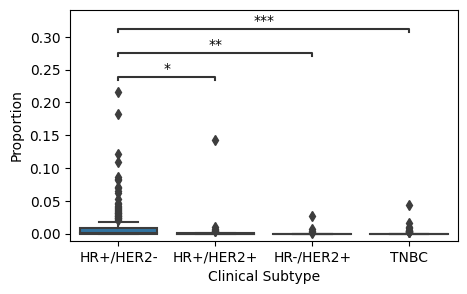

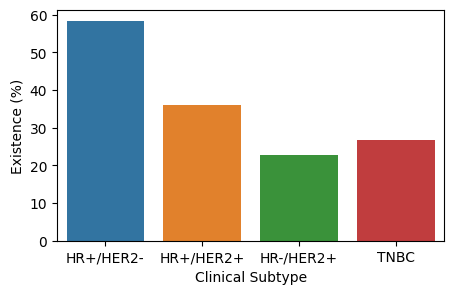

In [50]:

ER_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs])
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs])
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs])
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er= ER_status[i]
    pr= PR_status[i]
    her2= HER2_status[i]
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        Clinical_subtype[i] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        Clinical_subtype[i] = 'TNBC'
print("{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(len(Clinical_subtype),
np.sum(Clinical_subtype == 'HR+/HER2-'), np.sum(Clinical_subtype == 'HR+/HER2+'), np.sum(Clinical_subtype == 'HR-/HER2+'), np.sum(Clinical_subtype == 'TNBC')))

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id-1]
    DF_presentation = pd.DataFrame({
        'Occurence': histogram,
        'Clinical Subtype': Clinical_subtype,
    })
    DF_presentation = DF_presentation.loc[DF_presentation['Clinical Subtype'] != 0]
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x='Clinical Subtype', y='Occurence', data=DF_presentation, showfliers=True, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [("HR+/HER2-", "HR+/HER2+"), ("HR+/HER2-", "HR-/HER2+"), ("HR+/HER2-", "TNBC")],
        data=DF_presentation,
        x="Clinical Subtype",
        y="Occurence",
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    ax.set(ylabel = 'Proportion')

    DF_existence = pd.DataFrame({
        'Clinical Subtype': ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'],
    })
    for clinical_subtype in ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC']:
        data = DF_presentation.loc[DF_presentation['Clinical Subtype'] == clinical_subtype, 'Occurence'].values
        
        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[DF_existence['Clinical Subtype'] == clinical_subtype, 'Existence (%)'] = exisitence_ratio*100
        print("Pattern {} in {} has {:.0f}% of patients".format(pattern_id, clinical_subtype, exisitence_ratio * 100))
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(x='Clinical Subtype', y='Existence (%)', data=DF_existence, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])

### K-M Plot

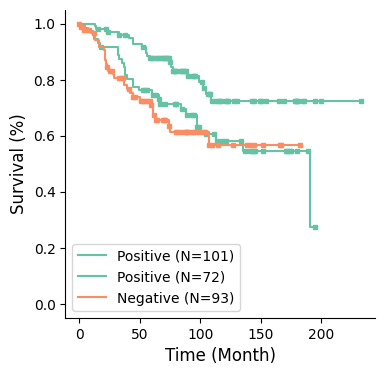

In [23]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
clinical_subtype="HR+/HER2-"
f, ax = plt.subplots(figsize=(4, 4))
histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

histogram = Histograms[:, Pattern_ids[0] - 1]
length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
    )
label = "Positive (N={})".format(len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )



length_B, event_observed_B = (
        Length[
            (Clinical_subtype != clinical_subtype)
      
        ],
        Status[
            (Clinical_subtype != clinical_subtype)

        ],
    )
label = "Negative (N={})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    # log_rank_test = multivariate_logrank_test(
    #     np.concatenate([length_A, length_B]),
    #     [0] * len(length_A) + [1] * len(length_B),
    #     np.concatenate([event_observed_A, event_observed_B]),
    # )
    # p_value = log_rank_test.p_value
    # ax.legend(fontsize=10)
    # ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()